In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', '..', '..', 'notebook_format'))

from formats import load_style
load_style(css_style='custom2.css', plot_style=False)

In [1]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import copy
import timm
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pytorch_lightning as pl
from datasets import Dataset
from time import perf_counter
from dataclasses import dataclass
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from transformers import DefaultDataCollator
from torchmetrics.classification import Accuracy
from pytorch_lightning.callbacks import ModelCheckpoint

%watermark -a 'Ethen' -d -u -v -iv

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Author: Ethen

Last updated: 2023-07-10

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 8.8.0

pytorch_lightning: 2.0.3
torchvision      : 0.15.2
timm             : 0.9.2
matplotlib       : 3.6.3
numpy            : 1.23.2
torch            : 2.0.1



# Self Supervised Versus Supervised Contrastive Learning

In this document, we'll be exploring both self-supervised and supervised contrastive learning.

In [2]:
@dataclass
class Config:
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    data_folder: str = "./data"

    # uses timm for model architecture
    model_name: str = "resnet50"
    pretrained: bool = True
    hidden_dim: int = 1024

    epochs: int = 20
    batch_size: int = 256
    num_workers: int = 4
    lr: float = 0.0001
    weight_decay: float = 0.0001

    linear_eval_epochs: int = 10
    linear_eval_batch_size: int = 256
    linear_eval_num_workers: int = 8
    linear_eval_lr: float = 0.0001
    linear_eval_weight_decay: float = 0.0001

    # note, we purpose-fully disabled the progress bar to prevent flooding our notebook's console
    # in normal settings, we can/should definitely turn it on
    enable_progress_bar = False

    do_train = True
    sim_clr_model_checkpoint = ""
    supervised_contrastive_model_checkpoint = ""


config = Config()

## Self Supervised Contrastive Learning with SIMCLR

Self-supervised learning's goal is to address the limitations of supervised learning, which heavily relies on labeled data. Acquiring large amounts of labeled data, and continuously annotating ground truth for new data can become quite expensive. One of the key advantages of self-supervised learning, or pre-training methods has gained significant popularity due to its ability to reduce the reliance on manual labeling. By leveraging abundant unlabeled data, we create proxy tasks derived from the data itself and pre-train our models on these tasks. These proxy tasks effectively transform the unsupervised learning problem into a supervised learning problem. Through pre-training, our models are "warmed up" and the expectation is to achieve competitive results on downstream applications by fine-tuning them on a smaller set of labeled data.

In this first section, we'll first looking at techniques for self supervised learning in the image field which relies on data augmentation and contrastive learning, called SIMCLR [[3]](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html) [[5]](https://arxiv.org/abs/2002.05709). SIMCLR's authors propose the following components to learn image representations from un-labeled images.

<img src="imgs/simclr.png" width="50%" height="50%">

1. Data Augmentation: In absence of label information, positive pairs are constructed by applying data augmentation techniques to the same sample. Specifically, a set of augmentations $\tau$ is applied twice to the original image, resulting in augmented views $\tilde{x_i}$, and $\tilde{x_j}$. While data augmentation has been commonly used in training image representations, it has not been considered as a means to define self-supervised pre-training tasks.
2. Backbone Encoder: A backbone or so called base encoder $f(\cdot)$ generates embedding representations, $h_i$ and $h_j$ from augmented data samples. End user has the flexibility to choose different network architectures or pre-trained models for this purpose.
3. Projection Network: A compact feedforward projection head $g(\cdot)$ maps embeddings $h_i$ to projected representations $z_i$. Empirically, it has been found beneficial to apply the contrastive loss to $z_i$ rather than directly to $h_i$. However, after training is completed, the projection head is discarded, and only $h_i$ is used for downstream tasks.
4. Contrastive learning. Given our embedding representation, we'll use InfoNCE style contrastive loss for training our embeddings. We'll explain more as we work our way through this implementation.

The next few code chunks, loads the CIFAR100 dataset, implements data augmentation transformation, prints out shapes from a data sample. 

> When composing multiple data augmentation methods together, the contrastive prediction task becomes harder, however, quality of learned representation also substantially improves. One combination that stood out was random cropping and color distortion.

In [3]:
class TwoViewTransform:
    """Create two crops of the same image"""

    def __init__(self, mean, std):
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

    def __call__(self, x):
        return [self.transform(x), self.transform(x)]

In [4]:
two_view_transform = TwoViewTransform(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
dataset_aug_pair_train = datasets.CIFAR100(
    root=config.data_folder,
    transform=two_view_transform,
    train=True,
    download=True
)
print("Dataset size:", len(dataset_aug_pair_train))
images, label = dataset_aug_pair_train[0]
print(images[0].shape)
print(images[1].shape)
print(label)

Files already downloaded and verified
Dataset size: 50000
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
19


In [5]:
data_loader_aug_pair_train = DataLoader(
    dataset_aug_pair_train,
    batch_size=4,
    num_workers=4,
    pin_memory=True
)

# we'll use a sample batch to test our model's forward implementation
aug_pair_batch = next(iter(data_loader_aug_pair_train))
aug_pair_images, aug_pair_labels = aug_pair_batch
print("labels: ", aug_pair_labels)
print("labels shape: ", aug_pair_labels.shape)
print("number of augmented images: ", len(aug_pair_images))
print("augmented image shape: ", aug_pair_images[0].shape)

labels:  tensor([19, 29,  0, 11])
labels shape:  torch.Size([4])
number of augmented images:  2
augmented image shape:  torch.Size([4, 3, 32, 32])


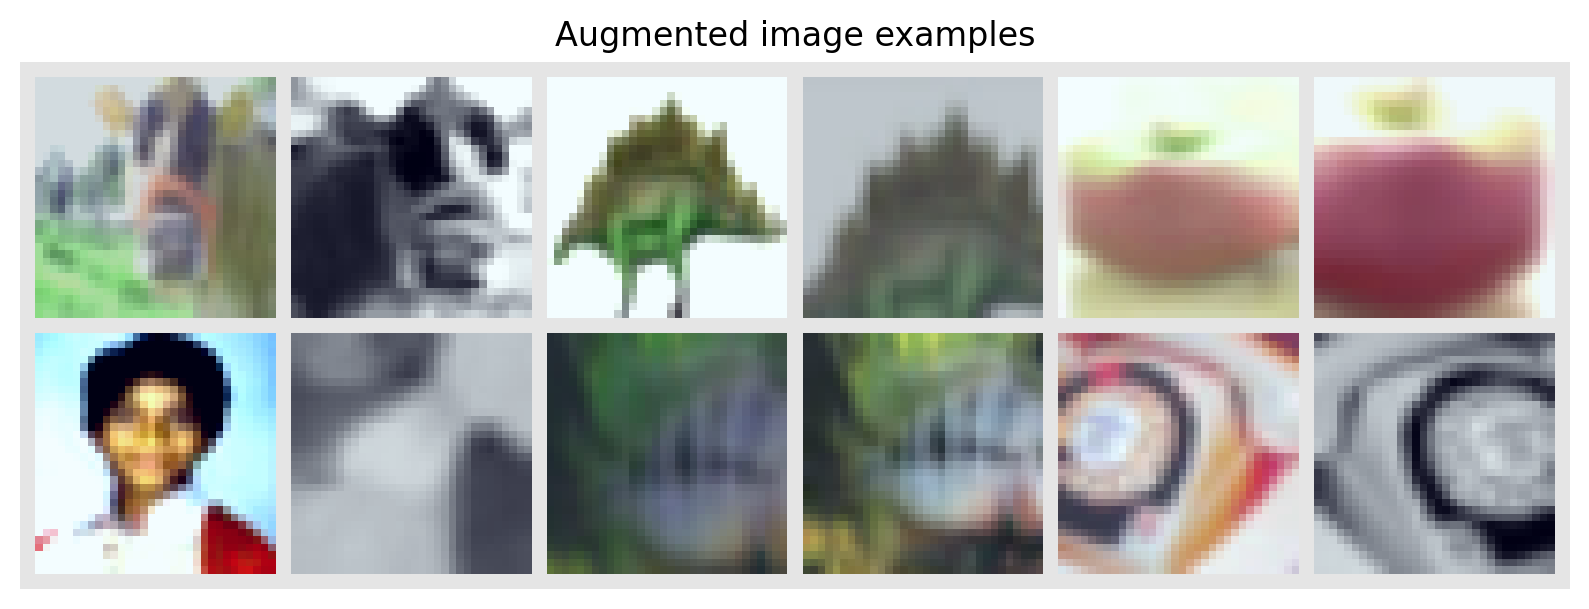

In [6]:
# visualize some sample augmented images
num_images = 6
imgs = torch.stack([img for idx in range(num_images) for img in dataset_aug_pair_train[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10, 5))
plt.title("Augmented image examples")
plt.imshow(img_grid)
plt.axis("off")
plt.show()

### SIMCLR Model

Given our input data, we'll implement the actual SIMCLR model. For our backbone, we'll be using resnet model family from `timm`, this is meant for quick experiment, feel free to adjust this and swap it with more powerful image/vision backbone encoder.

As for our contrastive loss, the loss function for a given positive pair of examples $(i, j)$ is defined as:

\begin{align}
-\sum_{i \in I} \log \frac{\exp \left(\operatorname{sim}\left(\boldsymbol{z}_i, \boldsymbol{z}_j\right) / \tau\right)}{\sum_{k=1}^{2 N} \mathbb{1}_{[k \neq i]} \exp \left(\operatorname{sim}\left(\boldsymbol{z}_i, \boldsymbol{z}_k\right) / \tau\right)}
\end{align}

- Given a mini-batch of $N$ examples, we have two augmented views derived from examples in this mini-batch, resulting in $2N$ data points.
- $\operatorname{sim}\left(\boldsymbol{z}_i, \boldsymbol{z}_j\right)$ denotes cosine similarity between the two embedding representation from projection layer.
- $\tau$ is a temperature scaler.
- $\mathbb{1}_{[k \neq i]}$ is an indicator evaluating to 1 if $k \neq i$.

The following figure serves as a usual illustration of where positives and negatives resides in a given contrastive learning training batch.

<img src="imgs/simclr_contrastive_loss.png" width="70%" height="70%">

In [7]:
class ContrastivePretrainedModel(pl.LightningModule):
    
    def __init__(
        self,
        model_name,
        pretrained,
        hidden_dim,
        lr,
        weight_decay
    ):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lr = lr
        self.model_name = model_name
        self.pretrained = pretrained
        self.weight_decay = weight_decay
        self.temperature = nn.Parameter(torch.ones([]) * 20)
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=4 * hidden_dim)
        # projection head is included as part of backbone's fc
        self.backbone.fc = nn.Sequential(
            self.backbone.fc,
            nn.ReLU(),
            nn.Linear(4 * hidden_dim, hidden_dim)
        )

        self.save_hyperparameters()

    def forward(self, batch):
        images, labels = batch
        images = torch.cat(images, dim=0)
        features = self.backbone(images)
        return features, labels
    
    def configure_optimizers(self):
        """
        Configure two parameter group, one that will have weight decay regularization enabled,
        and one that doesn't. Weight have one 1 dimension, e.g. bias term and normalization will
        have weight decay disabled.
        """
        params = [param for param in self.parameters() if param.requires_grad]
        decay_params = [param for param in params if param.dim() >= 2]
        nodecay_params = [param for param in params if param.dim() < 2]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")

        optim_groups = [
            {'params': decay_params, 'weight_decay': self.weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        return optim.AdamW(optim_groups, lr=self.lr)

In [8]:
class SimCLR(ContrastivePretrainedModel):

    def training_step(self, batch, batch_idx):
        features, labels = self(batch)

        # pairwise similarity
        cos_sim = F.cosine_similarity(features[:, None, :], features[None, :, :], dim=-1) * self.temperature
        # mask out itself from the calculation
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim = cos_sim.masked_fill(self_mask, -9e15)

        # construct label positions
        batch_size = labels.shape[0]
        augmented_batch_size = features.shape[0]
        labels = torch.cat([
            torch.arange(batch_size, augmented_batch_size, device=features.device),
            torch.arange(batch_size, device=features.device)
        ])

        loss = F.cross_entropy(cos_sim, labels)

        # we can also manually compute cross entropy
        # pos_mask = self_mask.roll(batch_size, dims=0)
        # nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        # loss = nll.mean()
        self.log("train_loss", loss, prog_bar=True)
        return loss

In [9]:
sim_clr = SimCLR(model_name="resnet18", pretrained=False, hidden_dim=128, lr=0.0001, weight_decay=0.0001)
features, labels = sim_clr(aug_pair_batch)
print("labels shape: ", labels.shape)
print("augmented images' feature shape: ", features.shape)

labels shape:  torch.Size([4])
augmented images' feature shape:  torch.Size([8, 128])


Given our model definition and dataset, we'll pass it through our trainer.

In [10]:
sim_clr = SimCLR(
    model_name=config.model_name,
    pretrained=config.pretrained,
    hidden_dim=config.hidden_dim,
    lr=config.lr,
    weight_decay=config.weight_decay
)
if config.sim_clr_model_checkpoint:
    sim_clr = sim_clr.load_from_checkpoint(config.sim_clr_model_checkpoint)

if config.do_train:
    checkpoint_callback = ModelCheckpoint(dirpath="sim_clr")
    trainer = pl.Trainer(
        accelerator="gpu",
        devices=-1,
        max_epochs=config.epochs,
        precision="16-mixed",
        enable_progress_bar=config.enable_progress_bar,
        log_every_n_steps=100,
        callbacks=[checkpoint_callback]
    )

    data_loader_aug_pair_train = DataLoader(
        dataset_aug_pair_train,
        batch_size=config.batch_size,
        num_workers=config.num_workers,
        pin_memory=True,
        shuffle=True
    )

    start = perf_counter()
    trainer.fit(sim_clr, data_loader_aug_pair_train)
    end = perf_counter()
    print("sim clr training elapsed: ", end - start)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type   | Params
------------------------------------
0 | backbone | ResNet | 36.1 M
------------------------------------
36.1 M    Trainable params
0         Non-trainable params
36.1 M    Total params
144.384   Total estimated model params size (MB)


num decayed parameter tensors: 55, with 36,037,824 parameters
num non-decayed parameter tensors: 109, with 58,241 parameters


`Trainer.fit` stopped: `max_epochs=20` reached.


sim clr training elapsed:  680.4121226710267


## Linear Evaluation

One approach to evaluate our learned representation is to use a linear evaluation protocol, where a linear classifier is trained on top of frozen base model. By freezing our base/backbone encoder, only if our model has learned generalized representation will it be able to perform well on downstream task. Here, we'll be using CIFAR10 as our benchmark dataset.

In [11]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])
dataset_benchmark_train = datasets.CIFAR10(
    root=config.data_folder,
    transform=transform_test,
    train=True,
    download=True
)
dataset_benchmark_test = datasets.CIFAR10(
    root=config.data_folder,
    transform=transform_test,
    train=False,
    download=True
)

Files already downloaded and verified
Files already downloaded and verified


The following implementation performs linear evaluation in two steps, we first encode all the images into feature representation using our backbone layer, then our linear evaluation will directly take these image representation as inputs as opposed to raw images. This has the benefit of speeding up training over multiple epochs as it avoids re-computing image repesentation over and over again.

In [12]:
class BackBone(pl.LightningModule):

    def __init__(self, model_name, hidden_dim, pretrained=False, normalize=True):
        super().__init__()
        self.model_name = model_name
        self.pretrained = pretrained
        self.hidden_dim = hidden_dim
        self.normalize = normalize
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=4 * hidden_dim)
        # projection head is included as part of backbone's fc, during
        # linear evaluation, we remove the projection head
        self.backbone.fc = nn.Identity()

    def forward(self, batch):
        images, labels = batch
        features = self.backbone(images)
        if self.normalize:
            features = F.normalize(features, p=2, dim=1)

        return features, labels

In [13]:
def create_feature_dataset(model, dataset_benchmark):
    backbone = BackBone(model.model_name, model.hidden_dim)
    backbone.load_state_dict(model.state_dict(), strict=False)

    data_loader_benchmark = DataLoader(
        dataset_benchmark,
        batch_size=64,
        num_workers=4,
        pin_memory=True,
        shuffle=False
    )

    # pytorch lightning returns prediction in batches,
    # we need to concatentate them together ourselves
    trainer = pl.Trainer(accelerator="gpu", devices=-1)
    predictions = trainer.predict(backbone, data_loader_benchmark)

    features_list = []
    labels_list = []
    for features, labels in predictions:
        features_list.append(features)
        labels_list.append(labels)

    features = torch.cat(features_list, dim=0)
    labels = torch.cat(labels_list, dim=0)
    return Dataset.from_dict({"features": features, "labels": labels})

In [14]:
dataset_feature_train = create_feature_dataset(sim_clr, dataset_benchmark_train)
dataset_feature_test = create_feature_dataset(sim_clr, dataset_benchmark_test)
print(dataset_feature_train)
print(dataset_feature_test)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 72.37it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 71.07it/s]
Dataset({
    features: ['features', 'labels'],
    num_rows: 50000
})
Dataset({
    features: ['features', 'labels'],
    num_rows: 10000
})


In [15]:
data_loader_feature_train = DataLoader(
    dataset_feature_train,
    batch_size=config.linear_eval_batch_size,
    num_workers=config.linear_eval_num_workers,
    pin_memory=True,
    shuffle=True,
    collate_fn=DefaultDataCollator()
)
data_loader_feature_test = DataLoader(
    dataset_feature_test,
    batch_size=config.linear_eval_batch_size,
    num_workers=config.linear_eval_num_workers,
    pin_memory=True,
    shuffle=False,
    collate_fn=DefaultDataCollator()
)
sample = next(iter(data_loader_feature_train))
feature_dim = sample["features"].shape[1]
sample

{'features': tensor([[0.0000, 0.2778, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0554, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
 'labels': tensor([0, 8, 2, 1, 0, 8, 4, 7, 9, 2, 7, 0, 2, 7, 0, 1, 0, 7, 9, 2, 7, 9, 3, 2,
         2, 5, 5, 3, 3, 4, 2, 9, 9, 5, 7, 9, 8, 8, 2, 9, 8, 1, 4, 4, 9, 6, 3, 1,
         8, 7, 7, 9, 4, 4, 0, 6, 5, 9, 3, 4, 1, 8, 2, 2, 2, 7, 2, 2, 1, 8, 5, 9,
         8, 8, 8, 4, 3, 1, 2, 1, 0, 5, 1, 2, 6, 0, 4, 1, 3, 6, 6, 9, 4, 0, 0, 7,
         7, 6, 8, 0, 6, 7, 8, 2, 0, 2, 3, 2, 0, 2, 1, 3, 3, 2, 4, 4, 1, 2, 4, 0,
         6, 5, 9, 1, 8, 3, 9, 9, 1, 2, 2, 9, 1, 0, 1, 8, 1, 6, 5, 5, 4, 1, 7, 1,
         0, 1, 5, 0, 3, 2, 5, 5, 6, 3, 4, 9, 3, 1, 3, 1, 4, 8, 7, 3, 4, 8, 6, 1,
     

In [16]:
class LinearClassifier(pl.LightningModule):

    def __init__(self, num_classes, feature_dim, lr, weight_decay):
        super().__init__()
        self.lr = lr
        self.weight_decay = weight_decay
        self.feature_dim = feature_dim
        self.num_classes = num_classes
        self.linear = nn.Linear(feature_dim, num_classes)
        self.accuracy_train = Accuracy(task="multiclass", num_classes=num_classes)

        self.save_hyperparameters()

    def forward(self, batch):
        features = batch["features"]
        labels = batch["labels"]
        logits = self.linear(features)
        return logits, labels

    def compute_loss(self, batch, mode):
        logits, labels = self(batch)
        loss = F.cross_entropy(logits, labels)

        predictions = logits.argmax(dim=-1)
        accuracy = self.accuracy_train(predictions, labels)

        self.log(f"{mode}_loss", loss, prog_bar=True)
        self.log(f"{mode}_accuracy", accuracy, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self.compute_loss(batch, mode="train")

    def test_step(self, batch, batch_idx):
        return self.compute_loss(batch, mode="test")

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)

In [17]:
linear_classifier = LinearClassifier(
    num_classes=10,
    feature_dim=feature_dim,
    lr=config.linear_eval_lr,
    weight_decay=config.linear_eval_weight_decay
)

trainer = pl.Trainer(
    accelerator="gpu",
    devices=-1,
    max_epochs=config.linear_eval_epochs,
    precision="16-mixed",
    enable_progress_bar=config.enable_progress_bar
)
trainer.fit(linear_classifier, data_loader_feature_train)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params
------------------------------------------------------
0 | linear         | Linear             | 20.5 K
1 | accuracy_train | MulticlassAccuracy | 0     
------------------------------------------------------
20.5 K    Trainable params
0         Non-trainable params
20.5 K    Total params
0.082     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=10` reached.


In [18]:
trainer.test(linear_classifier, data_loader_feature_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.5670999884605408
        test_loss            1.702192783355713
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.702192783355713, 'test_accuracy': 0.5670999884605408}]

## Supervised Contrastive Learning

The fundamental idea of supervised contrastive learning [[4]](https://ai.googleblog.com/2021/06/extending-contrastive-learning-to.html) [[6]](https://arxiv.org/abs/2004.11362) is to combine label information with self-supervised contrastive learning. In self-supervised learning, a positive example is created by applying data augmentation to the anchor, and it is contrasted against a set of negative samples. These negative samples are typically obtained from in-batch negatives, assuming a low likelihood of them being false negatives. Supervised contrastive learning "enhances" this by leveraging class labels on top of augmented views to contrast against negatives from the remaining samples.

<img src="imgs/supervised_contrastive.png" width="70%" height="70%">

This generates a representation where samples from the same class will be aligned better when compared against self supervised learning based methods. Note, with supervised contrastive learning, we will have to extend our contrastive loss to handle cases where there're more than 1 postives.


\begin{align}
-\sum_{i \in I} \frac{1}{|P(i)|} \sum_{p \in P(i)} \log \frac{\exp \left(\operatorname{sim}\left(\boldsymbol{z}_i, \boldsymbol{z}_p\right) / \tau\right)}{\sum_{k=1}^{2 N} \mathbb{1}_{[k \neq i]} \exp \left(\operatorname{sim}\left(\boldsymbol{z}_i, \boldsymbol{z}_k\right) / \tau\right)}
\end{align}

Where $P(i)$ is the indices of all positives in the multi-viewed batch.

This particular formula has the benefit of generalizing to arbitrary number of positives. Meaning for a given anchor, all positives, including the data augmentation based samples, as well as any remaining samples with the same label will contribute to the numerator of this equation. 

In [19]:
class SupervisedContrastiveModel(ContrastivePretrainedModel):

    def training_step(self, batch, batch_idx):
        features, labels = self(batch)

        # pairwise label equivalence, we also expand/repeat the pairwise
        # equivalence to be of the same size as the pairwise similarity
        # from the two augmented views
        labels_view = labels.view(-1, 1)
        labels_mask = torch.eq(labels_view, labels_view.T).float()
        labels_mask = labels_mask.repeat(2, 2)

        # pairwise similarity
        cos_sim = F.cosine_similarity(features[:, None, :], features[None, :, :], dim=-1) * self.temperature
        # mask out itself from the calculation
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim = cos_sim.masked_fill(self_mask, -9e15)

        # positive includes augmented samples and samples with the same label
        aug_pairs_mask = self_mask.roll(features.shape[0] // 2, dims=0)
        positive_mask = labels_mask * aug_pairs_mask

        # compute mean of log-likelihood over positive
        log_prob = cos_sim - torch.logsumexp(cos_sim, dim=-1, keepdim=True)
        mean_log_prob_positive = (log_prob * positive_mask).sum(dim=1) / positive_mask.sum(dim=1)
        loss = -1.0 * mean_log_prob_positive.mean()
        self.log("train_loss", loss, prog_bar=True)
        return loss

In [20]:
supervised_contrastive = SupervisedContrastiveModel(
    model_name="resnet18",
    pretrained=False,
    hidden_dim=1024,
    lr=0.0001,
    weight_decay=0.0001
)
features, labels = supervised_contrastive(aug_pair_batch)

In [21]:
supervised_contrastive = SupervisedContrastiveModel(
    model_name=config.model_name,
    pretrained=config.pretrained,
    hidden_dim=config.hidden_dim,
    lr=config.lr,
    weight_decay=config.weight_decay
)
if config.supervised_contrastive_model_checkpoint:
    supervised_contrastive = supervised_contrastive.load_from_checkpoint(
        config.supervised_contrastive_model_checkpoint
    )

if config.do_train:
    checkpoint_callback = ModelCheckpoint(dirpath="supervised_contrastive")
    trainer = pl.Trainer(
        accelerator="gpu",
        devices=-1,
        max_epochs=config.epochs,
        precision="16-mixed",
        # note, we purpose-fully disabled the progress bar to prevent flooding our notebook's console
        # in normal settings, we can/should definitely turn it on
        enable_progress_bar=config.enable_progress_bar,
        log_every_n_steps=100,
        callbacks=[checkpoint_callback]
    )

    data_loader_aug_pair_train = DataLoader(
        dataset_aug_pair_train,
        batch_size=config.batch_size,
        num_workers=config.num_workers,
        pin_memory=True,
        shuffle=True
    )

    start = perf_counter()
    trainer.fit(supervised_contrastive, data_loader_aug_pair_train)
    end = perf_counter()
    print("model training elapsed: ", end - start)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type   | Params
------------------------------------
0 | backbone | ResNet | 36.1 M
------------------------------------
36.1 M    Trainable params
0         Non-trainable params
36.1 M    Total params
144.384   Total estimated model params size (MB)


num decayed parameter tensors: 55, with 36,037,824 parameters
num non-decayed parameter tensors: 109, with 58,241 parameters


`Trainer.fit` stopped: `max_epochs=20` reached.


model training elapsed:  683.5580533358734


In [22]:
dataset_feature_train = create_feature_dataset(supervised_contrastive, dataset_benchmark_train)
dataset_feature_test = create_feature_dataset(supervised_contrastive, dataset_benchmark_test)
print(dataset_feature_train)
print(dataset_feature_test)

data_loader_feature_train = DataLoader(
    dataset_feature_train,
    batch_size=config.linear_eval_batch_size,
    num_workers=config.linear_eval_num_workers,
    pin_memory=True,
    shuffle=True,
    collate_fn=DefaultDataCollator()
)
data_loader_feature_test = DataLoader(
    dataset_feature_test,
    batch_size=config.linear_eval_batch_size,
    num_workers=config.linear_eval_num_workers,
    pin_memory=True,
    shuffle=False,
    collate_fn=DefaultDataCollator()
)

linear_classifier = LinearClassifier(
    num_classes=10,
    feature_dim=feature_dim,
    lr=config.linear_eval_lr,
    weight_decay=config.linear_eval_weight_decay
)

trainer = pl.Trainer(
    accelerator="gpu",
    devices=-1,
    max_epochs=config.linear_eval_epochs,
    precision="16-mixed",
    enable_progress_bar=config.enable_progress_bar
)
trainer.fit(linear_classifier, data_loader_feature_train)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 73.59it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 74.04it/s]


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params
------------------------------------------------------
0 | linear         | Linear             | 20.5 K
1 | accuracy_train | MulticlassAccuracy | 0     
------------------------------------------------------
20.5 K    Trainable params
0         Non-trainable params
20.5 K    Total params
0.082     Total estimated model params size (MB)


Dataset({
    features: ['features', 'labels'],
    num_rows: 50000
})
Dataset({
    features: ['features', 'labels'],
    num_rows: 10000
})


`Trainer.fit` stopped: `max_epochs=10` reached.


In [23]:
trainer.test(linear_classifier, data_loader_feature_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.5698000192642212
        test_loss           1.7018996477127075
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.7018996477127075, 'test_accuracy': 0.5698000192642212}]

### Final Notes

Contrastive learning based techniques benefits more from bigger models, stronger data augmentation as well as larger batch size compared to supervised learning counterparts:

- When composing multiple data augmentation methods together, the contrastive prediction task becomes harder, however, quality of learned representation also substantially improves. One combination that stood out was random cropping and color distortion. Reason being different crops of the same image often exhibit strong similarities in terms of color distribution. If the colors remain unaltered, a model can simply match the color histograms of the crops to maximize agreement, potentially overlooking other crucial and more generalizable representation. 
- Introducing a learnable nonlinear transformation between the respresentation and contrastive loss substantially improves the quality of learned representation. Even when introducing nonlinear transformation layer, backbone layer's representation is still a superior representation. Reason is nonlinear transformation has been trained to be invariant to data transformation. This invariance, while beneficial for contrastive learning settings, may lead to the removal of certain information that could be useful for downstream applications. By leveraging nonlinear transformations, more information can be preserved in the representations learned by the backbone layer.
    
As for supervised contrastive learning, authors from the paper claims this is the first contrastive loss to consistenly perform better than cross-entropy loss on large scale image classification problems.

# Reference

- [[1]](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial17/SimCLR.html) Tutorial 17: Self-Supervised Contrastive Learning with SimCLR
- [[2]](https://theaisummer.com/simclr/) Self-supervised learning tutorial: Implementing SimCLR with pytorch lightning
- [[3]](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html) Advancing Self-Supervised and Semi-Supervised Learning with SimCLR
- [[4]](https://ai.googleblog.com/2021/06/extending-contrastive-learning-to.html) Extending Contrastive Learning to the Supervised Setting
- [[5]](https://arxiv.org/abs/2002.05709) Ting Chen, Simon Kornblith, Mohammad Norouzi, Geoffrey Hinton - A Simple Framework for Contrastive Learning of Visual Representations - 2020
- [[6]](https://arxiv.org/abs/2004.11362) Prannay Khosla, Piotr Teterwak, et al. - Supervised Contrastive Learning - 2020